In [27]:
import re

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import wkt
from shapely.ops import cascaded_union

In [7]:
club = pd.read_csv('../data/original/clubs.csv', usecols=['longitud','latitud','nombre','capacidad','estado'])

In [12]:
club = club.dropna(subset=['estado'])

In [13]:
club = club.loc[club.estado.str.contains('RENOVADO 2018|INSCRIPCION 2018', flags=re.IGNORECASE, regex=True)]

In [15]:
club.loc[:, 'capacidad'] = club.capacidad.str.extract('([0-9]+)', expand=False).astype(int)

In [16]:
noclub = ['TEQUILA', 'BRANDY', 'BNN(BANANA)', 'GOLF DE PALERMO', 'JET', 'ROSE IN RIO',
          'CAIX', 'MANDARINE', 'OLIVIA ´S ', 'DORSIA', 'WESTERN ', 'ASIA DE CUBA']
club = club.loc[~club.nombre.isin(noclub)] 

In [21]:
longlatpairs = map(lambda x: f"POINT({x[0]} {x[1]})", zip(club.longitud, club.latitud))
club = club.assign(geometry = list(map(wkt.loads, longlatpairs)))

In [23]:
club = club.drop(columns=['longitud', 'latitud', 'estado']).reset_index(drop=True)

In [27]:
club.to_csv('../data/clubs.csv', index=False)

## Flag city blocks inside club area

In [13]:
city = pd.read_csv('../data/city.csv')

In [ ]:
city = city.assign(geometry = city.geometry.map(wkt.loads))

In [44]:
club = club.assign(area = club.geometry.map(lambda x: x.buffer(0.009)))

In [45]:
area = cascaded_union(club.area)

In [46]:
def intersect_area(shape, threshold=0.75):
    included = (shape.intersection(area).area / shape.area) >= threshold
    return 1 if included else 0

In [47]:
city = city.assign(club = city.geometry.map(intersect_area))

In [48]:
geocity = gpd.GeoDataFrame(city)

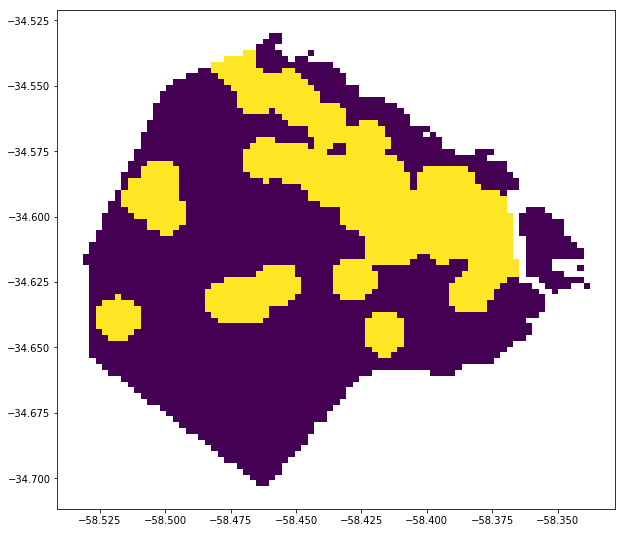

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
geocity.plot(column='club', ax=ax)

In [51]:
city.to_csv('../data/city.csv', index=False)